# Summary
In Season 12, the strike zone formula is this:
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.90,
                 minroll
                 + 0.35*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```

In Season 13, the strike zone formula is modified. The The max possible value for a strike goes DOWN from 0.90 to 0.85, and the ruthlessness coefficient goes DOWN from 0.35 to 0.30. This formula holds for Season 13 and Season 14:
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.85,
                 minroll
                 + 0.3*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```

In Season 15, the strike zone formula changes slightly *again*. The max possible value for a strike goes UP from 0.85 to 0.86, and the ruthlessness coefficient goes DOWN from 0.3 to 0.285 (a 5% decrease):
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.86,
                 minroll
                 + 0.285*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```


## Load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from csv_dtypes import column_dtypes

import load

In [14]:
season = 18
df = load.data("strikes", season=season)

flinch_data = False

df["ruth_vibes"] = load.player_attribute(
    # These values are mandatory: the dataframe, the player role, and the attribute
    df, 'pitcher', 'ruthlessness',
    # These are all optional, and the default values are as they appear here
    vibes=True, mods=True, items=True, broken_items=False
)
df["cold_vibes"] = load.player_attribute(df, 'pitcher', 'coldness')

df["musc_scaled"] = load.player_attribute(df, 'batter', 'musclitude', vibes=False)
df["mox_scaled"] = load.player_attribute(df, 'batter', 'moxie', vibes=False)

# center=True is the default
df["forwardness"] = load.stadium_attribute(df, 'forwardness', center=True)

In [15]:
df.columns

Index(['event_type', 'roll', 'passed', 'what1', 'what2', 'batting_team_hype',
       'pitching_team_hype', 'game_id', 'play_count', 'ball_count',
       'strike_count', 'out_count', 'home_score', 'away_score', 'inning',
       'baserunner_count', 'baserunners', 'baserunners_next', 'is_strike',
       'strike_roll', 'strike_threshold', 'fielder_roll',
       'batter_consecutive_hits', 'weather', 'season', 'day', 'runner_count',
       'top_of_inning', 'is_maximum_blaseball', 'batter_at_bats',
       'batter_file', 'batting_team_file', 'pitcher_file',
       'pitching_team_file', 'stadium_file', 'fielder_file',
       'relevant_runner_file', 'runner_on_first_file', 'runner_on_second_file',
       'runner_on_third_file', 'runner_on_third_hh_file', 'attacked_team_file',
       'stat_relevant_data', 'pitcher_object', 'batter_object',
       'batting_team_object', 'pitching_team_object', 'stadium_object',
       'pitcher_vibes', 'pitcher_mods', 'pitcher_name', 'batter_vibes',
       'batter_

In [16]:
# df["ruth_cold"] = (9 * df["ruth_vibes"] + 1 * df["cold_vibes"]) / 10
# df["ruth_cold"] = df["ruth_vibes"] * df["cold_scaled"]
# df["musc_mox"] = df["musc_scaled"] * df["mox_scaled"]
# df["musc_sq"] = df["musc_scaled"] ** 2
# df["mox_sq"] = df["mox_scaled"] ** 2

# powers = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9",
#     "1.0", "1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1.7", "1.8", "1.9", "2.0",
#          "2.1", "2.2", "2.3", "2.4", "2.5", "2.6", "2.7", "2.8", "2.9", "3.0"]
# for pow in powers:
#     df["musc_"+pow] = df["musc_scaled"] ** float(pow)
#     df["mox_"+pow] = df["mox_scaled"] ** float(pow)


# df["roll_mod"] = df["roll"] - 0.29 * df["ruth_cold"] - 0.12 * df["ballpark_forwardness"] - 0.34
# df["roll_log"] = np.log(df["roll_mod"])
# df["musc_log"] = np.log(df["musc_scaled"])
# df["mox_log"] = np.log(df["mox_scaled"])
# df["musc_mox_log"] = np.log(df["musc_mox"])


# # put in our "best fit" up here in the original df, just because
# if season == 11:
#     print("using season " + str(season + 1) + " formula")
#     df["svc_best"] = 0.35 * df["ruth_vibes"] + 0.20 * df["ballpark_forwardness"] + 0.10 * df["musc_scaled"]
# elif season == 12 or season == 13:
#     print("using season " + str(season + 1) + " formula")
#     df["svc_best"] = 0.30 * df["ruth_vibes"] + 0.20 * df["ballpark_forwardness"] + 0.10 * df["musc_scaled"]
# elif season == 14:
#     print("using season " + str(season + 1) + " formula")
#     df["svc_best"] = 0.285 * df["ruth_vibes"] + 0.20 * df["ballpark_forwardness"] + 0.10 * df["musc_scaled"]

## Filter data
Handles swapping between flinch and no-flinch situations, and excluding things like ON_FIRE.

In [21]:
# temporary fix for OVERUNDER not working in this branch
def overunder_fix(row):
    pm = str(row["pitcher_mods"])
    if ("OVERUNDER" in pm
        and "UNDERPERFORMING" not in pm):
        if row["top_of_inning"]:
            # curry is on the home team
            if row["home_score"] >= 5.0:
                return pm + ";UNDERPERFORMING"
        else:
            # curry is on the away team
            if row["away_score"] >= 5.0:
                return pm + ";UNDERPERFORMING"
    else:
        return pm

In [55]:
# df = df[df["batter_mods"].isna() & df["pitcher_mods"].isna()]
dfc = df.copy()
# dfc["pitcher_mods"] = df.apply(overunder_fix, axis=1)
dfc = dfc[(dfc["batting_team_hype"] == 0) & (dfc["pitching_team_hype"] == 0)]
for exclude_mod in ["ON_FIRE", "PSYCHIC", "PARASITE", "MINIMALIST", "MAXIMALIST",
                    "OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["ON_FIRE", "PSYCHIC", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["ON_FIRE", "PSYCHIC", "PARASITE", "MINIMALIST", "MAXIMALIST"]:
# for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]


for exclude_mod in ["FLINCH"]:
    dfc["flinch"] = (dfc["batter_mods"].astype(str).str.contains(exclude_mod)) & (dfc["strike_count"] == 0)
    print(dfc.groupby("flinch").size())
    if flinch_data:
        dfc = dfc[dfc["flinch"]]
    else:
        dfc = dfc[~dfc["flinch"]]
#     dfc["flinch"] = dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)
# dfc.groupby("flinch").size()

# excluding one weird data point in season 18 that seems incorrect
for exclude_points in [("080c2816-0fff-4e55-bb9a-8dd547f4e3b1", 41),
                      ("7d782994-a4fb-469d-9942-e97def670e23", 168)]:
    dfc = dfc[~((dfc["game_id"] == exclude_points[0]) & (dfc["play_count"] == exclude_points[1]))]


   
powers = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9",
    "1.0", "1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1.7", "1.8", "1.9", "2.0",
         "2.1", "2.2", "2.3", "2.4", "2.5", "2.6", "2.7", "2.8", "2.9", "3.0"]
for pow in powers:
    dfc["musc_"+pow] = dfc["musc_scaled"] ** float(pow)
    dfc["mox_"+pow] = dfc["mox_scaled"] ** float(pow)



flinch
False    11247
True       316
dtype: int64


In [56]:
# # print(list(df.columns))
# print(len(df))
# print(len(dfc))
# out_cols = [
#     "event_type",
#     "roll",
#     "passed",
#     "game_id",
#     "play_count",
#     "batter_mods",
#     "pitcher_mods",
#     "batting_team_mods",
#     "pitching_team_mods",
# ]
# df_export = dfc.loc[:, out_cols].sort_values(["game_id", "play_count"])
# df_export.to_csv(f"../test-cached-object-logging.csv", index=False)

In [57]:
# # df_import = pd.read_csv("../test-item-attribute-testing.csv")
# # df_export = df_import.loc[:, out_cols].sort_values(["game_id", "play_count"])
# # df_export.to_csv("../test-item-attribute-testing.csv", index=False)
# print_cols = [
#     "event_type",
#     "roll",
#     "passed",
#     "game_id",
#     "play_count",
#     # "batter_name",
#     # "pitcher_name",
#     "batter_mods",
#     "pitcher_mods",
#     "batting_team_mods",
#     "pitching_team_mods",
#     "home_score",
#     "away_score",
#     "ball_count",
#     "strike_count",
#     "out_count",
#        ]

In [58]:
# ";".join(sorted(df_export.iloc[0, 7].split(";")))

In [59]:
# def sort_this(row, colname):
#     if not pd.isna(row[colname]):
#         return ";".join(sorted(row[colname].split(";")))
#     else:
#         return ""


# df_import = pd.read_csv("../test-item-attribute-testing.csv", dtype=column_dtypes)
# df_import["batter_mods"] = df_import.apply(sort_this, axis=1, args=("batter_mods",))
# df_import["batting_team_mods"] = df_import.apply(sort_this, axis=1, args=("batting_team_mods",))
# df_import["pitcher_mods"] = df_import.apply(sort_this, axis=1, args=("pitcher_mods",))
# df_import["pitching_team_mods"] = df_import.apply(sort_this, axis=1, args=("pitching_team_mods",))
# df_import.to_csv("../test-item-attribute-testing.csv", index=False)


# df_import = pd.read_csv("../test-cached-object-logging.csv", dtype=column_dtypes)
# df_import["batter_mods"] = df_import.apply(sort_this, axis=1, args=("batter_mods",))
# df_import["batting_team_mods"] = df_import.apply(sort_this, axis=1, args=("batting_team_mods",))
# df_import["pitcher_mods"] = df_import.apply(sort_this, axis=1, args=("pitcher_mods",))
# df_import["pitching_team_mods"] = df_import.apply(sort_this, axis=1, args=("pitching_team_mods",))
# df_import.to_csv("../test-cached-object-logging.csv", index=False)


In [60]:
df.loc[(df["game_id"] == "133dbfb1-b94a-4003-afb8-4ff9d2b1161a") & (df["play_count"] == 210),
       out_cols]

NameError: name 'out_cols' is not defined

In [61]:

df.loc[(df["game_id"] == "18f2cc84-b5ad-49d7-87bc-f47afa8b2e81") &
       (df["pitcher_mods"].astype(str).str.contains("OVERUNDER")),
       print_cols]


NameError: name 'print_cols' is not defined

In [62]:
df.loc[(df["game_id"] == "432fdc41-5ec1-4c37-ad0f-6567e5254721") &
       (df["play_count"] == 93),
       print_cols]

NameError: name 'print_cols' is not defined

In [63]:
print(str(df.loc[(df["game_id"] == "1eb40035-c99c-4162-8ad6-3e24405209d7") &
       (df["play_count"] == 104),
       "batter_object"][2930]))
df.loc[(df["game_id"] == "1eb40035-c99c-4162-8ad6-3e24405209d7") &
       (df["play_count"] == 104),
       print_cols]

PlayerData(mods=set(), _TeamOrPlayerMods__mods_by_type={<ModType.PERMANENT: 0>: set(), <ModType.SEASON: 1>: set(), <ModType.WEEK: 2>: set(), <ModType.GAME: 3>: set(), <ModType.ITEM: 4>: set()}, id='97af97a7-19dc-4d18-9f72-8bd89f7eeaa8', last_update_time='2021-05-20T17:20:01.105984Z', raw_name='Trinity Smaht', unscattered_name=None, data={'id': '97af97a7-19dc-4d18-9f72-8bd89f7eeaa8', 'fate': 24, 'name': 'Trinity Smaht', 'soul': 6, 'blood': 7, 'items': [{'id': 'c15c4379-4b61-4d7a-93a1-5d274598db89', 'name': 'Mesh Hot Glove', 'root': {'name': 'Glove', 'adjustments': [{'stat': 21, 'type': 1, 'value': 0.11072503607207757}]}, 'forger': None, 'health': 0, 'suffix': None, 'prefixes': [{'name': 'Mesh', 'adjustments': [{'stat': 3, 'type': 1, 'value': 0.3140911735633987}, {'stat': 18, 'type': 1, 'value': -0.1127235401913835}]}, {'name': 'Hot', 'adjustments': [{'stat': 2, 'type': 1, 'value': 0.316237112732962}, {'stat': 17, 'type': 1, 'value': -0.11773575056392785}, {'stat': 3, 'type': 1, 'value':

NameError: name 'print_cols' is not defined

In [ ]:
print(str(df.loc[(df["game_id"] == "e682bb46-75ef-488d-8c52-9e622a32a4eb") &
       (df["play_count"] == 63),
       "batter_object"].iloc[0]))
df.loc[(df["game_id"] == "e682bb46-75ef-488d-8c52-9e622a32a4eb") &
       (df["play_count"] == 63),
       print_cols]


In [64]:
digest_list = [
    "event_type",
    "roll",
    "threshold",
    "batter_name",
    "pitcher_name",
    "ruth_vibes",
    # "pitcher_vibes",
    "musc_scaled",
    "mox_scaled",
    "ballpark_forwardness",
    "game_id",
    "play_count",
    # "svc_best",
]
# dfc.groupby(["batting_team_mods"]).size()

## SVC fit

In [65]:
dfc["musc_pow"] = dfc["musc_0.5"]
dfc["mox_pow"] = dfc["mox_1.5"]
dfc["musc_mox"] = dfc["musc_pow"] * dfc["mox_pow"]

In [66]:
# X = dfc[['passed', 'roll', 'ruth_vibes', 'ballpark_forwardness', 'musc_scaled']].copy()
X = dfc[["passed",
         "roll",
         # "roll_mod",
         # "roll_log",
         "ruth_vibes",
         "cold_vibes",
         # "ruth_cold",
         "forwardness",
         # "musc_scaled",
         # "mox_scaled",
         "musc_mox",
         "musc_pow",
         "mox_pow",
         # "musc_log",
         # "mox_log",
         # "musc_mox_log",
         # "mox_vibes",
         # "batting_team_hype",
         # "pitching_team_hype",
         ]].copy()
X = X[X["roll"] < 0.86]
# attributes may or may not be allowed to go negative with items. exclude cases where this might happen
# and which would throw off the non-integer power i'm testing
X = X[~np.isnan(X.iloc[:,-1])]
X = X[~np.isnan(X.iloc[:,-2])]
# X = X[X["roll_mod"] > 0]
# X["roll"] = X["roll"] - 0.2 * X["ballpark_forwardness"]
# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]
y = X["passed"]
X = X.drop(["passed"], axis=1)
# X = X.drop(["roll"], axis=1)
# X = X.drop(["roll_mod"], axis=1)

pin_intercept = None
# pin_intercept = 0.34
pins = [
    # (-0.075, "batting_team_hype"),
    # (0.060, "pitching_team_hype"),
    # (0.29, "ruth_cold"),
    # (0.12, "ballpark_forwardness"),
    # (0.075, "musc_scaled"),
    # (-0.08, "mox_scaled"),
    # (0.08, "musc_mox"),
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]
    
print(X["roll"].max())
print(X.shape)

0.8599502790290696
(8786, 7)


In [67]:
# dfc.loc[dfc["pitching_team_mods"].astype(str).str.contains("FIREPROOF"), 
#             [
#         # "offset",  # "home_score", "away_score", "top_of_inning", "inning",
#         "pitcher_mul",
#         "batter_mul",
#         "event_type",
#         "roll",
#         # "threshold",
#         # "svc",
#         # "ruth_vibes",
#         "batter_vibes",
#         "batter_moxie",
#         # "ballpark_forwardness",
#         # "pitcher_coldness",
#         "batter_name",
#         "pitcher_name",
#         "batter_mods",
#         "pitcher_mods",
#         "batting_team_mods",
#         "pitching_team_mods",
#         "day",
#         "game_id",
#         "play_count",
#         "weather",
#          # 'ball_count',
#          # 'strike_count',
#          # 'out_count'
#     ]
#        ]

In [68]:
dfc.loc[(dfc["game_id"] == "133dbfb1-b94a-4003-afb8-4ff9d2b1161a") & (dfc["play_count"] == 210),
       print_cols]

NameError: name 'print_cols' is not defined

In [69]:
dfc.loc[(dfc["game_id"] == "18f2cc84-b5ad-49d7-87bc-f47afa8b2e81") & (dfc["play_count"] < 27),
       print_cols]

NameError: name 'print_cols' is not defined

In [70]:
dfc.loc[(dfc["game_id"] == "133dbfb1-b94a-4003-afb8-4ff9d2b1161a") & (dfc["play_count"] == 210),
       print_cols]

NameError: name 'print_cols' is not defined

In [71]:
trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=10000000, fit_intercept=pin_intercept is None,
                           tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
sc.inverse_transform(trainedsvm.coef_)
trainedsvm.coef_
sc.scale_
trainedsvm.score(X2, y)
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

print(intercept_scaled, ", intercept")
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)

[[4725   20]
 [  39 4002]]
              precision    recall  f1-score   support

       False       0.99      1.00      0.99      4745
        True       1.00      0.99      0.99      4041

    accuracy                           0.99      8786
   macro avg       0.99      0.99      0.99      8786
weighted avg       0.99      0.99      0.99      8786

0.993284771226952
0.3227996576551564 , intercept
(0.2642000172438834, 'ruth_vibes')
(0.02438824750506279, 'cold_vibes')
(0.11646470690799747, 'forwardness')
(0.09778240050412017, 'musc_mox')
(0.06158008912660706, 'musc_pow')
(-0.1569594500466917, 'mox_pow')


## Calculate threshold from fit

In [72]:
if flinch_data:
    intercept = 0.50
else:
    intercept = 0.30
if season == 11:
    dfc["threshold"] = (intercept
                        + 0.35 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.90
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
elif season == 12 or season == 13:
    dfc["threshold"] = (intercept
                        + 0.30 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.85
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
elif season in [14, 15, 16, 17]:
    dfc["threshold"] = (intercept
                        + 0.285 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.86
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
# elif season == 18:
#     intercept = 0.275 # 1/3
#     dfc["threshold"] = (intercept
#                         + 0.275 * dfc["ruth_vibes"] # + 0.285 * dfc["ruth_vibes"]
#                         + 0.025 * dfc["cold_vibes"] # + 0.0285 * dfc["cold_vibes"]
#                         + 0.115 * dfc["ballpark_forwardness"] # + 0.125 * dfc["ballpark_forwardness"]
#                         + 0.075 * dfc["musc_scaled"] # + 0.08 * dfc["musc_scaled"]
#                         - 0.095 * dfc["mox_scaled"] # - 0.10 * dfc["mox_scaled"]
#                        )
#     dfc["svc"] = dfc["threshold"] - intercept
#     strikemax = 0.86
#     dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
else:
    intercept = intercept_scaled
    dfc['threshold'] = intercept_scaled
    print(intercept_scaled)
    for pair in pins + list(zip(-np.array(coef_list), X.columns)):
        if "roll" not in pair[1]:
            print(pair)
            dfc['threshold'] += pair[0] * dfc[pair[1]]
    # dfc['threshold'] += 0.2 * dfc['ballpark_forwardness']
    dfc["svc"] = dfc["threshold"] - intercept_scaled
    strikemax = 0.86
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax


# dfc['svc'] = 0
# # print(-intercept_scaled)
# for pair in zip(-np.array(coef_list), X.columns):
#     if pair[1] != "roll":
#         # print(pair)
#         dfc['svc'] += pair[0] * dfc[pair[1]]
# dfc['svc'] += 0.2 * dfc['ballpark_forwardness']

# kidror's rounding:
#  0.275 + 0.275*ruth + 0.115*dfc["ballpark_forwardness"] + 0.075*dfc["batter_musclitude"]
# - 0.095*dfc["batter_moxie"] + 0.025*cold

0.3227996576551564
(0.2642000172438834, 'ruth_vibes')
(0.02438824750506279, 'cold_vibes')
(0.11646470690799747, 'forwardness')
(0.09778240050412017, 'musc_mox')
(0.06158008912660706, 'musc_pow')
(-0.1569594500466917, 'mox_pow')


In [73]:
dfc_strikes = dfc[dfc["event_type"] == "StrikeLooking"]
dfc_flinch = dfc[dfc["event_type"] == "StrikeFlinching"]
dfc_balls = dfc[dfc["event_type"] == "Ball"]

## Find Outliers

season
18    59
dtype: int64


,offset,event_type,roll,threshold,ruth_vibes,cold_vibes,pitcher_mods,pitching_team_mods,day,game_id,play_count,weather,day
13829,-0.071665,Ball,0.652622,0.724286,1.366350,1.368855,OVERUNDER,HOME_FIELD;O_NO,82,48f50618-e7b1-4936-b2d8-8031728317ba,280,1,82
13702,-0.066226,Ball,0.658060,0.724286,1.366350,1.368855,OVERUNDER,HOME_FIELD;O_NO,82,48f50618-e7b1-4936-b2d8-8031728317ba,240,1,82
22045,-0.052294,Ball,0.541066,0.593359,1.176168,1.178325,OVERUNDER,O_NO,66,d0cb8a62-faac-43c8-8b9c-560e8a5027b9,357,17,66
68607,-0.049106,Ball,0.657481,0.706587,1.176168,1.178325,OVERUNDER,O_NO,38,26c3c2b5-4496-44a0-a98b-3162930cddad,222,9,38
68972,-0.040211,Ball,0.696196,0.736407,1.176168,1.178325,OVERUNDER,O_NO,38,26c3c2b5-4496-44a0-a98b-3162930cddad,335,9,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60063,0.012838,StrikeLooking,0.449087,0.436249,0.411274,0.137988,,,31,c004977d-9fb5-4abb-bc62-893671f478b8,365,18,31
58311,0.013428,StrikeLooking,0.673066,0.659638,1.056190,1.378669,INTUITIVE,POPCORN_PAYOUTS,30,bb26b966-5340-4a47-a0d5-845d88a83c92,202,14,30
21927,0.016149,StrikeLooking,0.563396,0.547247,0.785643,0.133645,,BOTTOM_DWELLER;BLACKHOLE_PAYOUTS,66,d0cb8a62-faac-43c8-8b9c-560e8a5027b9,295,17,66
43,0.044039,StrikeLooking,0.730792,0.686754,1.307899,1.257799,,BASE_INSTINCTS;LATE_TO_PARTY;LIFE_OF_PARTY,72,08d140db-04b8-4a37-b22a-c032e511a45d,23,16,72


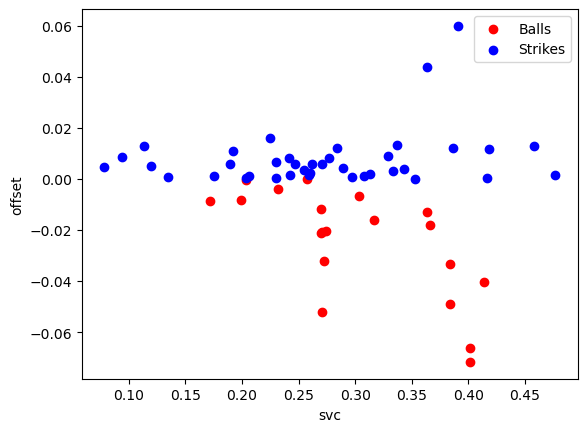

In [74]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "svc"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Balls",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Strikes",
)
# ax.scatter(
#     outliers[outliers["pitcher_mods"].astype(str).str.contains("OVERUNDER")][x_val],
#     outliers[outliers["pitcher_mods"].astype(str).str.contains("OVERUNDER")]["offset"],
#     color="black",
#     label="Curry",
# )
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

table = outliers

# table.groupby(["batting_team_mods"]).size()
# pd.set_option("display.max_rows", 100)  # default 60
# outliers_by_pitcher = table.groupby(["pitcher_name"]).size()
# pitches_by_pitcher = dfc.groupby(["pitcher_name"]).size()

# outlier_fraction = pitches_by_pitcher.copy()
# for pitcher in outlier_fraction.index:
#     if pitcher in outliers_by_pitcher.index:
#         outlier_fraction[pitcher] = outliers_by_pitcher[pitcher]/pitches_by_pitcher[pitcher]
#     else:
#         outlier_fraction[pitcher] = 0


# outliers_by_batter = table.groupby(["batter_name"]).size()
# pitches_by_batter = dfc.groupby(["batter_name"]).size()

# outlier_fraction_b = pitches_by_batter.copy()
# for batter in outlier_fraction_b.index:
#     if batter in outliers_by_batter.index:
#         outlier_fraction_b[batter] = outliers_by_batter[batter]/pitches_by_batter[batter]
#     else:
#         outlier_fraction_b[batter] = 0
# outlier_fraction.sort_values()
# dfc.groupby(["pitcher_name"]).size().sort_values()
print(outliers.groupby("season").size())
pd.set_option("display.max_rows", 10)  # default 60
table[#.loc[#table["pitching_team_mods"].astype(str).str.contains("FIREPROOF"),
    [
        "offset",  # "home_score", "away_score", "top_of_inning", "inning",
        # "pitcher_mul",
        # "batter_mul",
        "event_type",
        "roll",
        "threshold",
        # "svc",
        "ruth_vibes",
        "cold_vibes",
        # "pitcher_ruthlessness",
        # "batter_vibes",
        # "mox_scaled",
        # "musc_scaled",
        # "ballpark_forwardness",
        # "pitcher_coldness",
        # "batter_name",
        # "pitcher_name",
        # "batter_mods",
        "pitcher_mods",
        # "batting_team_mods",
        "pitching_team_mods",
        "day",
        "game_id",
        "play_count",
        "weather",
        #  'ball_count',
        #  'strike_count',
        #  'out_count',
        # "inning",
        # "home_score",
        # "away_score",
        # "top_of_inning",
        "day",
    ]
].sort_values("offset")#.loc[table["pitcher_mods"].astype(str).str.contains("OVERUNDER"), :]
# pd.set_option("display.max_rows", 60)  # default 60

In [42]:
# plt.plot(np.arange(len(outlier_fraction))/len(outlier_fraction), outlier_fraction.sort_values(), '.-')
# plt.plot(np.arange(len(outlier_fraction_b))/len(outlier_fraction_b), outlier_fraction_b.sort_values(), '.-')
# pd.set_option("display.max_rows", 300)  # default 60
# print(outlier_fraction.sort_values())
# print(outliers_by_pitcher.sort_values())
# print(outlier_fraction_b.sort_values())
pd.set_option("display.max_rows", 60)  # default 60

## Visualize Threshold

Text(0.5, 0.98, 'Season 19, Non-Flinching')

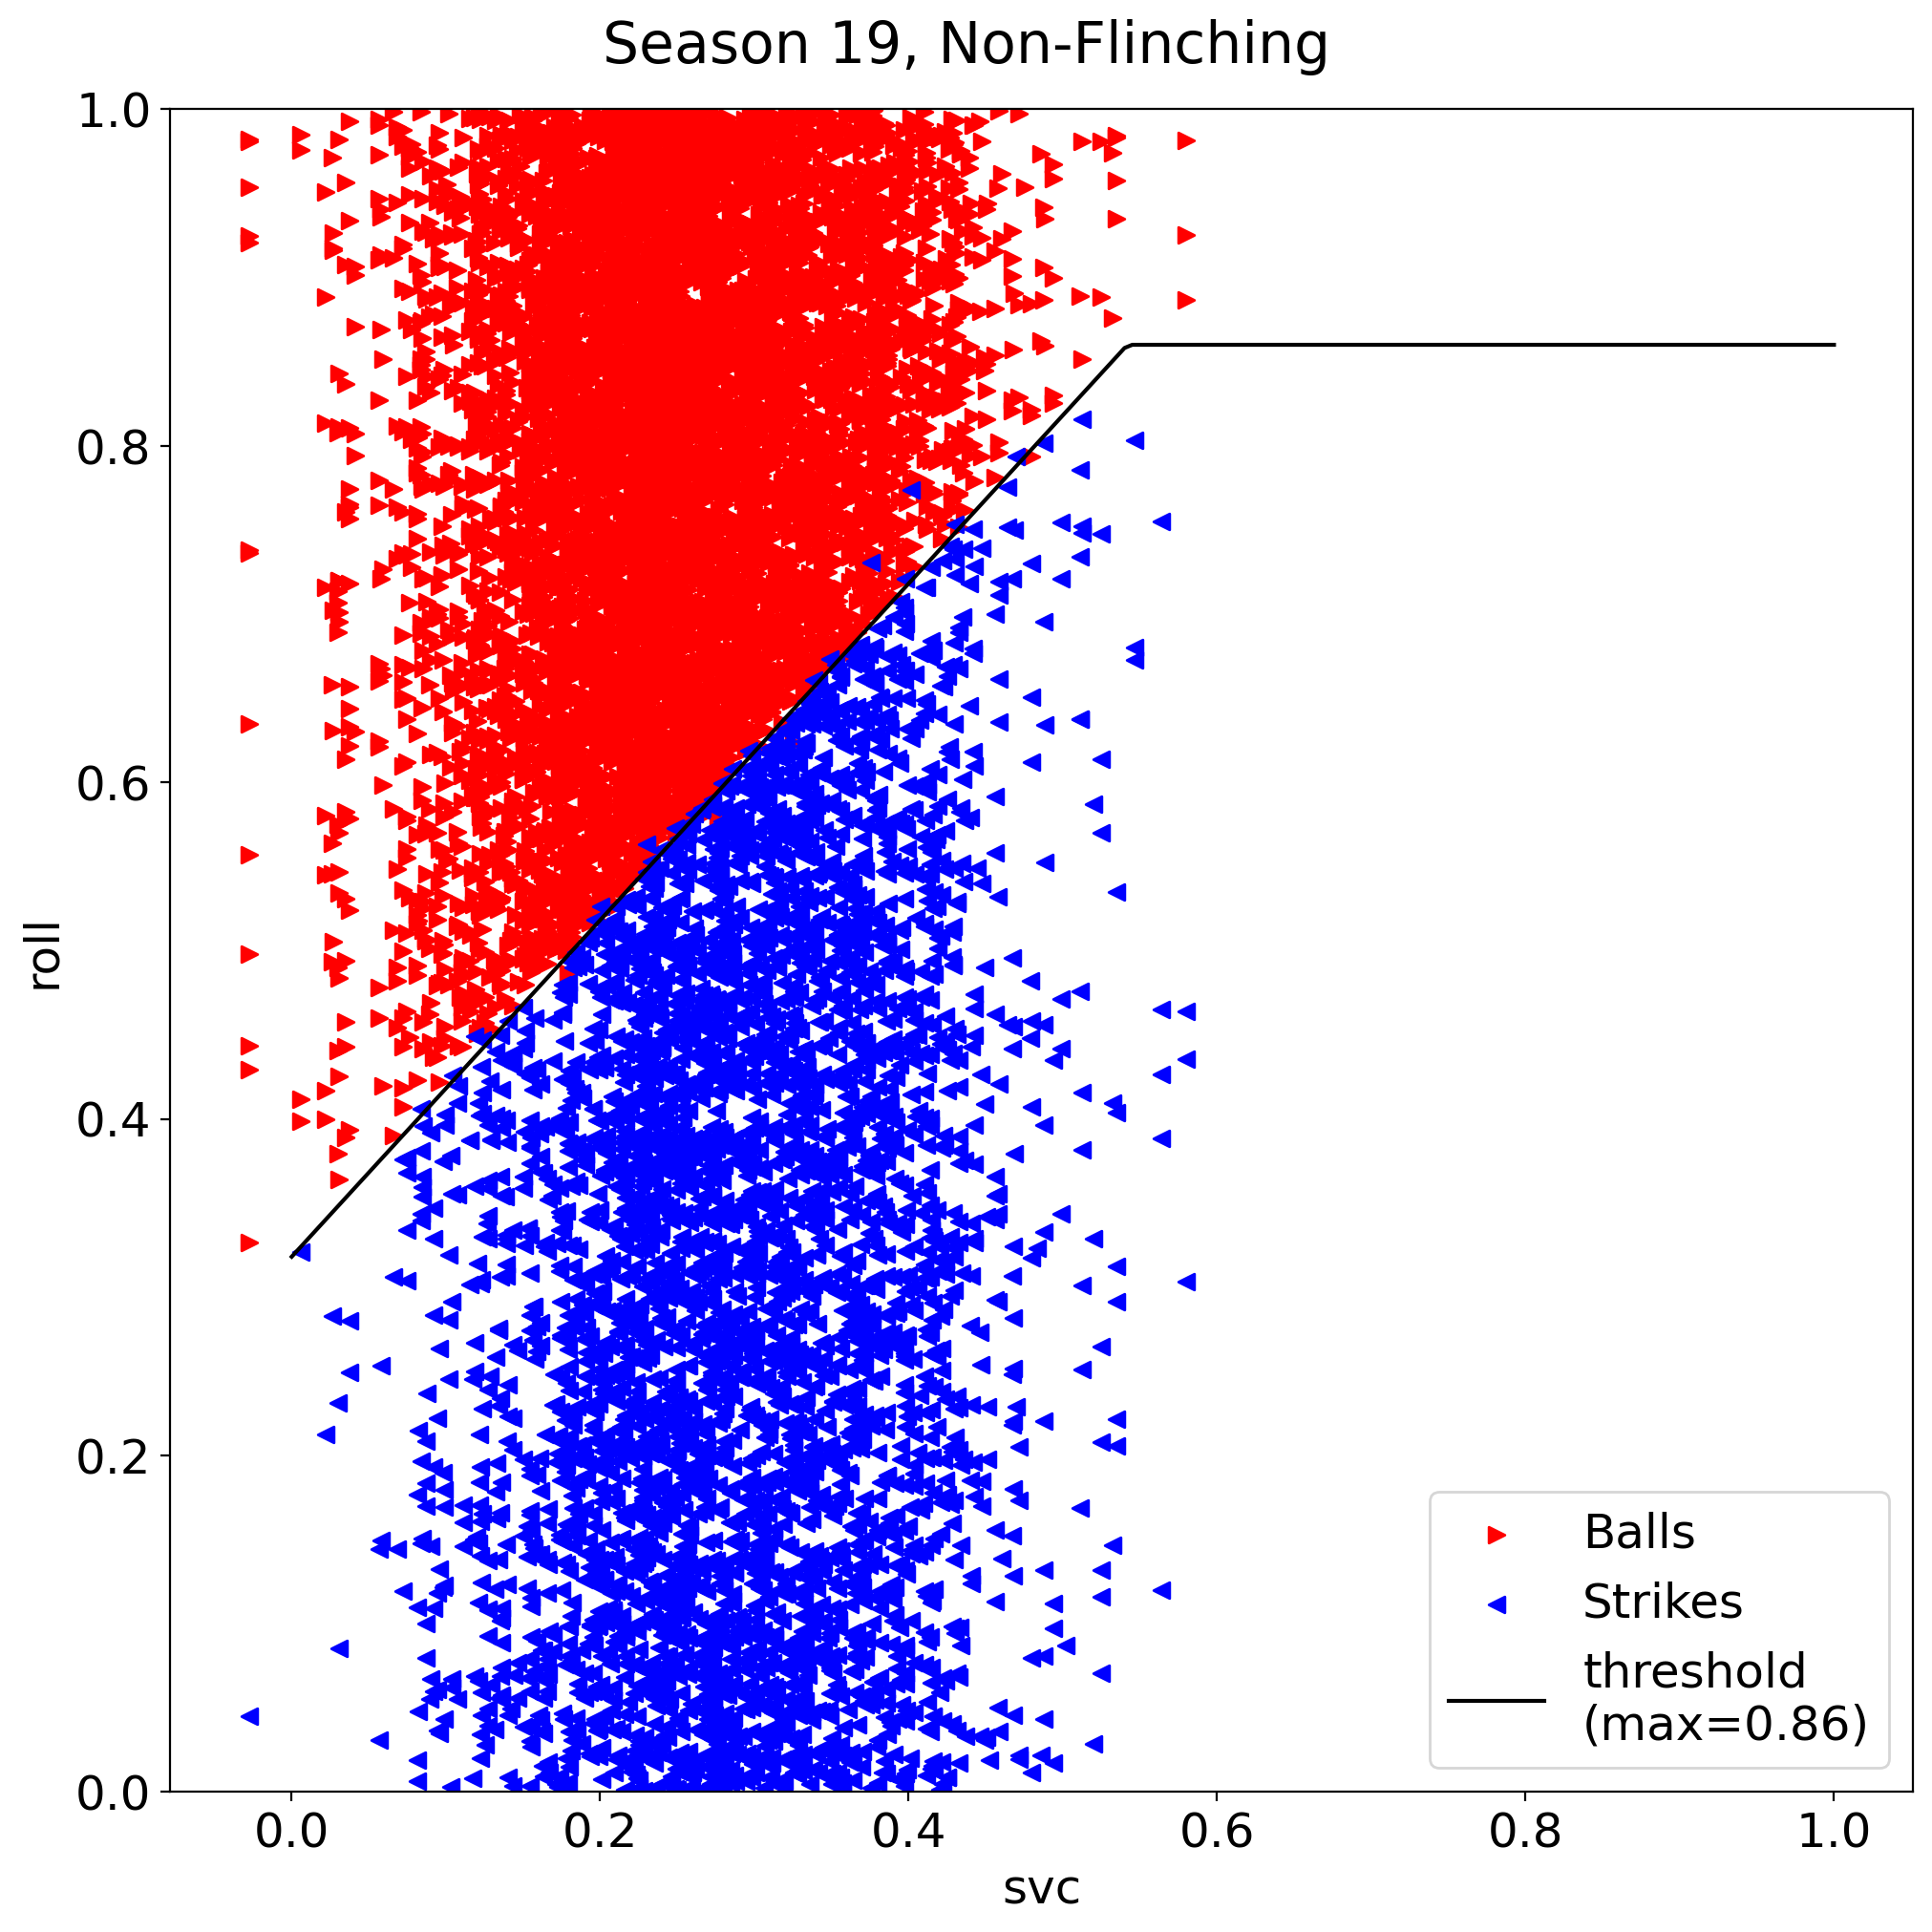

In [43]:
# x_val = "pitcher_ruthlessness"

plt.rcParams["font.size"] = 18
x_val = "svc"
fig, ax = plt.subplots(1, figsize=(10, 10), dpi=200, layout="constrained")

intercept_plot = intercept
# intercept_plot = -intercept_scaled
xline = np.linspace(0, 1, 201)
# xline = np.insert(xline, 1, 0.65)
yline = intercept_plot + xline
# yline = xline
yline[(yline > strikemax)] = strikemax

# ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="Balls",
    marker=">",
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Strikes",
    marker="<",
)
# ax.set_xlim(-0.05, 1.05)
ax.plot(xline, yline, "k", label=f"threshold\n(max={strikemax})")
# ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["roll"],
#            s=48, edgecolor='black', color="red", label="Balls (below threshold)", marker='<')
# ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["roll"],
#            s=48, edgecolor='black', color="blue", label="Strikes (above threshold)", marker='>')
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.plot(dfc["svc"].min(), 0.5, 'o')

ax.legend(loc="lower right")
fig.suptitle(f"Season {season+1}, {'' if flinch_data else 'Non-'}Flinching")
# fig.savefig(f"../figures/strikes_s{season+1}{'_flinch' if flinch_data else '_noflinch'}.png",
#             facecolor='white', dpi=200)


In [44]:
outliers.groupby("season").size()

season
18    38
dtype: int64

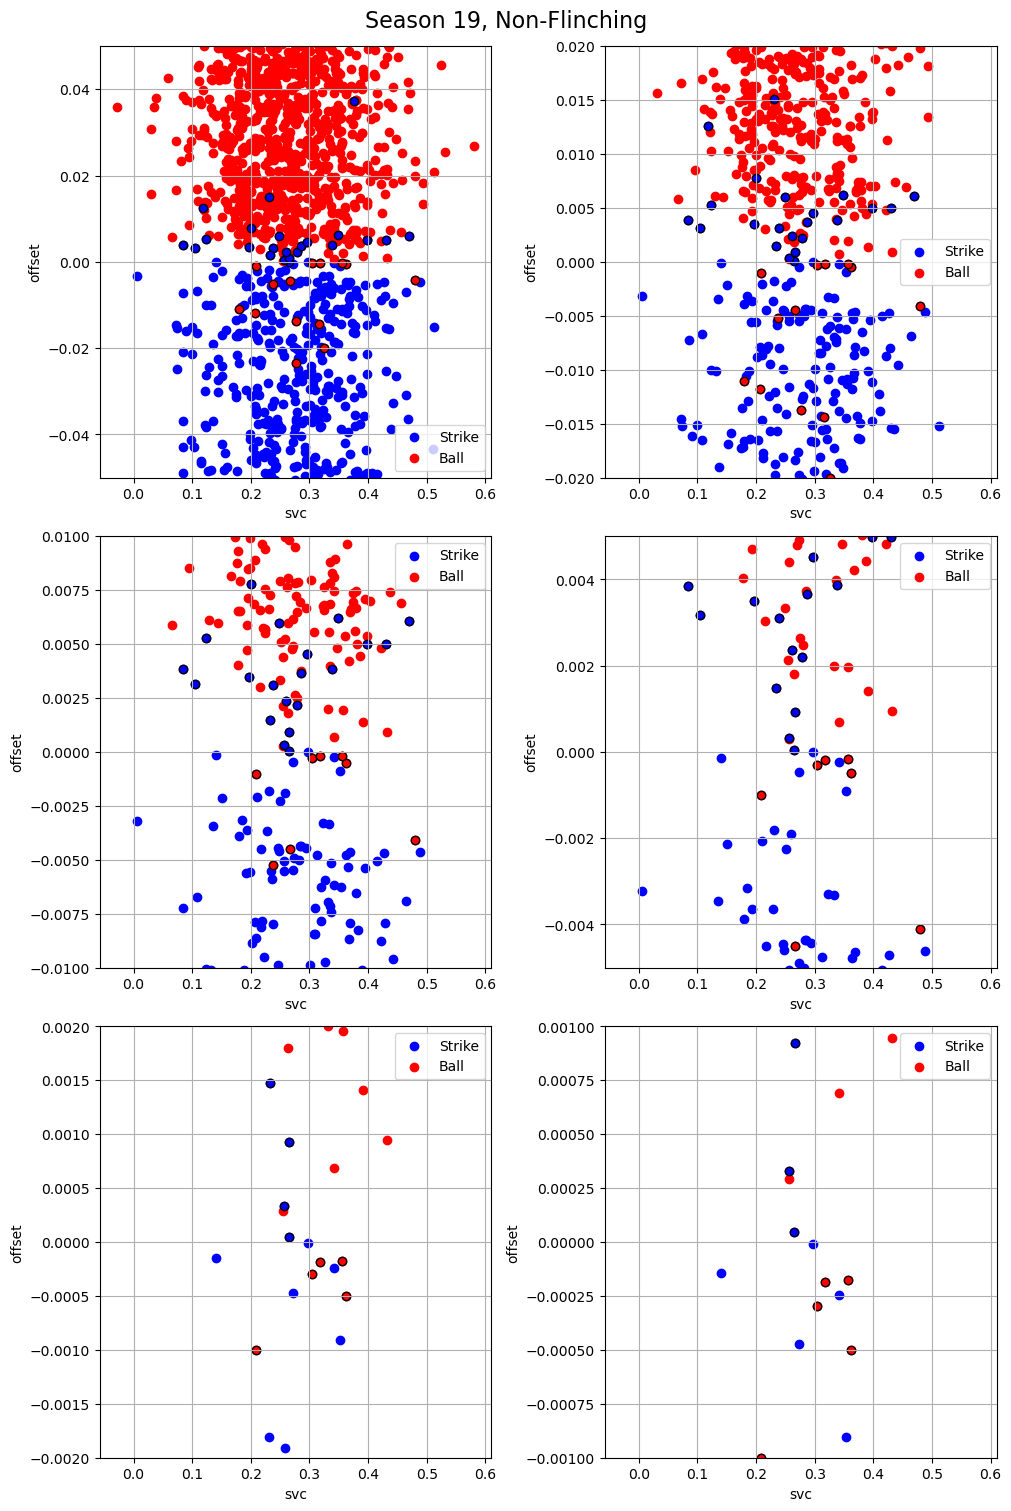

In [45]:
plt.rcParams["font.size"] = 10
x_val = "svc"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
fig.suptitle(f"Season {season+1}, {'' if flinch_data else 'Non-'}Flinching", fontsize=16)
dimlist = [5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Strike",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="Ball",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig(f"../figures/ball_strike_fit_offsets_season{season+1}{'_flinch' if flinch_data else '_noflinch'}.png",
#             facecolor='white')


In [46]:
# cutoff = 0.86 + intercept_scaled[0]
cutoff = 0.86 - intercept
print(round(cutoff, 6))
print(dfc_balls['roll'].max())
print(dfc_flinch['roll'].max())
print(dfc_strikes['roll'].max())
# print(dfc_balls[dfc_balls['svc'] > cutoff]['roll'].min())
# print(dfc_balls[dfc_balls['svc'] > cutoff]['roll'].argmin())
# dfc_balls[dfc_balls['svc'] > cutoff].iloc[dfc_balls[dfc_balls['svc'] > cutoff]['roll'].argmin(),:]
# print(dfc_flinch[dfc_flinch['svc'] > 0.86 + intercept_scaled[0]]['roll'].max())

0.54189
0.9999806832535514
nan
0.8154846859640053


In [47]:
print(dfc_balls['roll'].min())
print(dfc_flinch['roll'].min())
print(dfc_strikes['roll'].min())

0.3265759853975571
nan
0.0005312572265958


In [48]:
0.86 - intercept_scaled

0.5418896482380657

In [49]:
# df["svc"].min()

In [50]:
# df["svc_best"].max()

In [121]:
# df.iloc[df["svc_best"].argmax(), :][70:]

In [122]:
# dfc["threshold"] = -1 * (\
#     1.0 * -0.20 + \
#     -0.30 * dfc["ruth_scaled"] + \
#     -0.20 * dfc["ballpark_forwardness"] + \
#     -0.10 * dfc["musc_scaled"] + \
#     -0.06 * dfc["ruth_vibes"])
# dfc["threshold"] = -1 * (\
#     coef_scaled[0,0] * intercept_scaled + \
#     coef_scaled[0,1] * dfc["ruth_scaled"] + \
#     coef_scaled[0,2] * dfc["ballpark_forwardness"] + \
#     coef_scaled[0,3] * dfc["ruth_vibes"] + \
#     coef_scaled[0,4] * dfc["musc_scaled"] + \
#     coef_scaled[0,5] * dfc["flinch"])
# dfc.loc[(dfc["threshold"] > 0.85), "threshold"] = 0.85


# dfc["offset"] = dfc["roll"] - dfc["threshold"]

# outliers = dfc.copy()[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
# print(len(outliers))

# fig, ax = plt.subplots(1)
# fig.set_size_inches(10, 10)
# x_val = "svc"
# ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["offset"], color="red", label="Balls")
# ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["offset"], color="blue", label="Strikes")
# ax.set_xlabel(x_val)
# ax.set_ylabel('offset')
# ax.grid()
# ax.legend()
# ax.set_xlim(0, 1.4)
# ax.set_xlim(0.1, 0.7)
# ax.set_ylim(-0.06, 0.08)
# fig.savefig("fit_outliers.png", facecolor='white')

In [134]:
# dfc_flinch.loc[:,["roll", "ruth_vibes", "pitcher_name", "svc"]].sort_values("ruth_vibes")

In [ ]:
dfc_flinch["svc"].min()

In [125]:
df_strikes = df[df["event_type"] == "StrikeLooking"]
df_flinch = df[df["event_type"] == "StrikeFlinching"]
df_balls = df[df["event_type"] == "Ball"]

In [126]:
print(df_balls['roll'].min())
print(df_flinch['roll'].min())
print(df_strikes['roll'].min())

0.009235878301657
0.0004467073582588
4.970715327123898e-06


In [127]:
print(df_balls['roll'].max())
print(df_flinch['roll'].max())
print(df_strikes['roll'].max())

0.9999952780379446
0.8575403860443549
0.8591372830492274


In [133]:
# game = df[(df["batter_name"] == "Zesty Yaboi")]
# game

## Grid Search

In [51]:
powers = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9",
    "1.0", "1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1.7", "1.8", "1.9", "2.0",
         "2.1", "2.2", "2.3", "2.4", "2.5", "2.6", "2.7", "2.8", "2.9", "3.0"]
scores = np.zeros((len(powers), len(powers)))
for i, pow1 in enumerate(powers):
    for j, pow2 in enumerate(powers):
        # print("=================================================")
        # print("musc_"+pow1, "mox_"+pow2)
        # print("=================================================")
        dfc["musc_pow"] = dfc["musc_"+pow1]
        dfc["mox_pow"] = dfc["mox_"+pow2]
        dfc["musc_mox"] = dfc["musc_pow"] * dfc["mox_pow"]

        # X = dfc[['passed', 'roll', 'ruth_vibes', 'ballpark_forwardness', 'musc_scaled']].copy()
        X = dfc[["passed",
                 "roll",
                 # "roll_mod",
                 # "roll_log",
                 "ruth_vibes",
                 "cold_vibes",
                 # "ruth_cold",
                 "forwardness",
                 # "musc_scaled",
                 # "mox_scaled",
                 "musc_mox",
                 "musc_pow",
                 "mox_pow",
                 # "musc_log",
                 # "mox_log",
                 # "musc_mox_log",
                 # "mox_vibes",
                 # "batting_team_hype",
                 # "pitching_team_hype",
                 ]].copy()
        X = X[X["roll"] < 0.86]
        # attributes may or may not be allowed to go negative with items. exclude cases where this might happen
        # and which would throw off the non-integer power i'm testing
        X = X[~np.isnan(X.iloc[:,-1])]
        X = X[~np.isnan(X.iloc[:,-2])]
        # X = X[X["roll_mod"] > 0]
        # X["roll"] = X["roll"] - 0.2 * X["ballpark_forwardness"]
        # X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
        # X = dfc[['roll', 'pitcher_ruthlessness']]
        y = X["passed"]
        X = X.drop(["passed"], axis=1)
        # X = X.drop(["roll"], axis=1)
        # X = X.drop(["roll_mod"], axis=1)

        pin_intercept = None
        # pin_intercept = 0.34
        pins = [
            # (-0.075, "batting_team_hype"),
            # (0.060, "pitching_team_hype"),
            # (0.29, "ruth_cold"),
            # (0.12, "ballpark_forwardness"),
            # (0.075, "musc_scaled"),
            # (-0.08, "mox_scaled"),
            # (0.08, "musc_mox"),
        ]
        for val, var in pins:
            X["roll_log"] -= X[var] * val
            X = X.drop(var, axis=1)

        sc = StandardScaler(with_mean=False)
        X2 = sc.fit_transform(X)
        if pin_intercept is not None:
            X2[:, 0] -= pin_intercept / sc.scale_[0]

        # print(X["roll"].max())
        # print(X.shape)


        trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=10000000, fit_intercept=pin_intercept is None,
                                   tol=1e-10).fit(X2, y)
        predictionsvm = trainedsvm.predict(X2)
        # print(confusion_matrix(y, predictionsvm))
        # print(classification_report(y, predictionsvm))
        sc.inverse_transform(trainedsvm.coef_)
        trainedsvm.coef_
        sc.scale_
        scores[i, j] = trainedsvm.score(X2, y)
        # print(scores[i, j])

# print the last one, just for fun
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept
            
print(intercept_scaled, ", intercept")
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)
        pass

0.3163250876814779 , intercept
(0.26590248859854665, 'ruth_vibes')
(0.032737181875553606, 'cold_vibes')
(0.1023603089932232, 'forwardness')
(0.0020712930256387646, 'musc_mox')
(0.02631273925288506, 'musc_pow')
(-0.03917561018813252, 'mox_pow')


Text(0, 0.5, 'musclitude exponent')

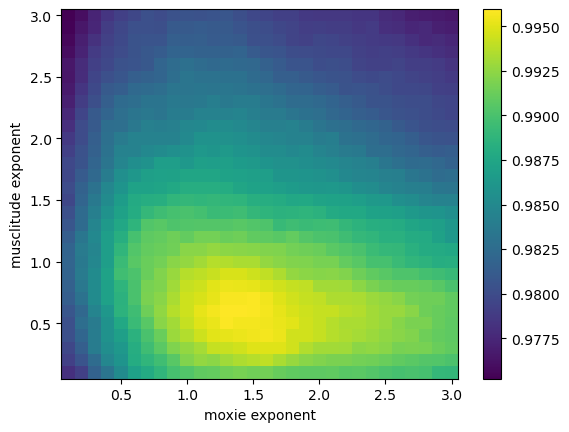

In [52]:
xx = np.array([float(i) for i in powers])
plt.pcolormesh(xx, xx, scores)#, vmin=0.9935, vmax=0.997)
plt.colorbar()
plt.xlabel("moxie exponent")
plt.ylabel("musclitude exponent")

In [54]:
print(scores.max())
print(np.unravel_index(scores.argmax(), scores.shape))
print(xx[np.unravel_index(scores.argmax(), scores.shape)[0]], xx[np.unravel_index(scores.argmax(), scores.shape)[1]])
# scores[0:3,:]

0.9959668126296382
(5, 12)
0.6 1.3


In [129]:
# X = dfc[["passed",
#          "roll",
#          # "roll_mod",
#          # "roll_log",
#          "ruth_vibes",
#          "cold_vibes",
#          # "pitcher_vibes",
#          # "ruth_cold",
#          # "opw_vibes",
#          # "shakes_vibes",
#          # "supp_vibes",
#          # "unthwk_vibes",
#          "ballpark_forwardness",
#          # 'ballpark_grandiosity',
#          # 'ballpark_fortification',
#          # 'ballpark_obtuseness',
#          # 'ballpark_ominousness',
#          # 'ballpark_inconvenience',
#          # 'ballpark_viscosity',
#          # 'ballpark_mysticism',
#          # 'ballpark_elongation',
#          "musc_scaled",
#          "mox_scaled",
#          "musc_mox",
#          "musc_pow",
#          "mox_pow",
#          # "musc_log",
#          # "mox_log",
#          # "musc_mox_log",
#          # "mox_vibes",
#          # "fielder_roll",
#          # "batter_buoyancy",
#          # "batter_divinity",
#          # "batter_martyrdom",
#          # "batter_moxie",
#          # "batter_musclitude",
#          # "batter_patheticism",
#          # "batter_thwackability",
#          # "batter_tragicness",
#          # "batter_coldness",
#          # "batter_overpowerment",
#          # "batter_ruthlessness",
#          # "batter_shakespearianism",
#          # "batter_suppression",
#          # "batter_unthwackability",
#          # "batter_anticapitalism",
#          # "batter_chasiness",
#          # "batter_omniscience",
#          # "batter_tenaciousness",
#          # "batter_watchfulness",
#          # "batter_base_thirst",
#          # "batter_continuation",
#          # "batter_ground_friction",
#          # "batter_indulgence",
#          # "batter_laserlikeness",
#          # "batter_pressurization",
#          # "batter_cinnamon",
#          # "batter_vibes",
#          # "batting_team_hype",
#          # "pitching_team_hype",
#          # "inning",
#          ]].copy()